In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [2]:
df = pd.read_csv('train.csv', index_col=['date'], parse_dates=['date'])

In [3]:
df = df.drop(columns=["row_id"])

In [4]:
df.index.is_monotonic_increasing

True

In [5]:
df.head()

,country,store,product,num_sold
date,,,,
2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2017-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   70128 non-null  object
 1   store     70128 non-null  object
 2   product   70128 non-null  object
 3   num_sold  70128 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


# Анализ признаков

In [7]:
df["country"].value_counts()

country
Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: count, dtype: int64

In [8]:
df["store"].value_counts()

store
KaggleMart    35064
KaggleRama    35064
Name: count, dtype: int64

In [9]:
df["product"].value_counts()

product
Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: count, dtype: int64

In [10]:
translations = {}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

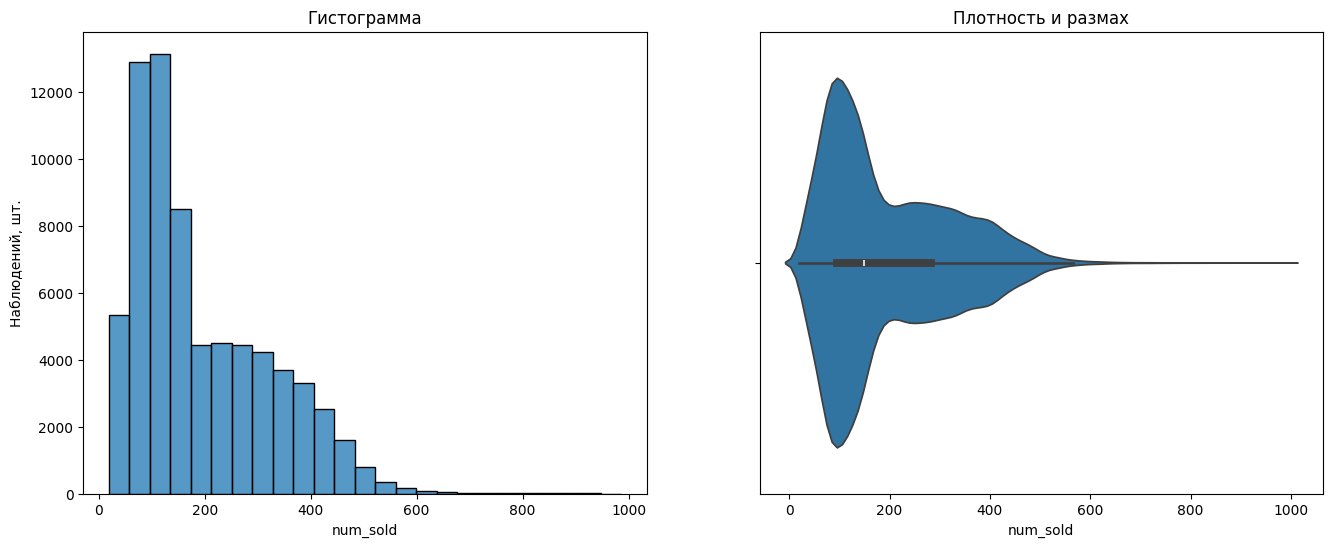

In [11]:
eda_visualize(df["num_sold"])

# Моделирование

In [12]:
df_Belgium = (
    df[(df["product"] == "Kaggle Recipe Book") & (df["country"] == "Belgium")]
    .drop(columns=["country", "product"])
    .groupby(['store']).resample('1d', include_groups=False).sum()
    .reset_index("store")
    .sort_index()
)

In [13]:
df_Belgium['month'] = df_Belgium.index.month
df_Belgium['dayofweek'] = df_Belgium.index.dayofweek

In [14]:
df_Belgium_train = df_Belgium.loc[:'2019-12-31']
df_Belgium_test = df_Belgium.loc['2020-01-01':]

In [15]:
X_train = df_Belgium_train.drop(columns=["num_sold"])
y_train = df_Belgium_train["num_sold"]

In [16]:
X_test = df_Belgium_test.drop(columns=["num_sold"])
y_test = df_Belgium_test["num_sold"]

In [17]:
model = LinearRegression()
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform='pandas'), ["store"]),
    ],
    remainder='passthrough',
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler()),
    ('model', model),
])
params = {}

gs = GridSearchCV(
    pipeline,
    params,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

gs.fit(X_train, y_train)

print(f"MAE: {mean_absolute_error(y_test, gs.best_estimator_.predict(X_test)):.2f}")
print(f"MSE: {mean_squared_error(y_test, gs.best_estimator_.predict(X_test)):.2f}")
print(f"R2: {r2_score(y_test, gs.best_estimator_.predict(X_test)):.2f}")

MAE: 27.45
MSE: 1377.67
R2: 0.79


MAE: 27.45
MSE: 1377.67
R2: 0.79

In [18]:
predictions = pd.Series(gs.best_estimator_.predict(X_test), index=y_test.index)

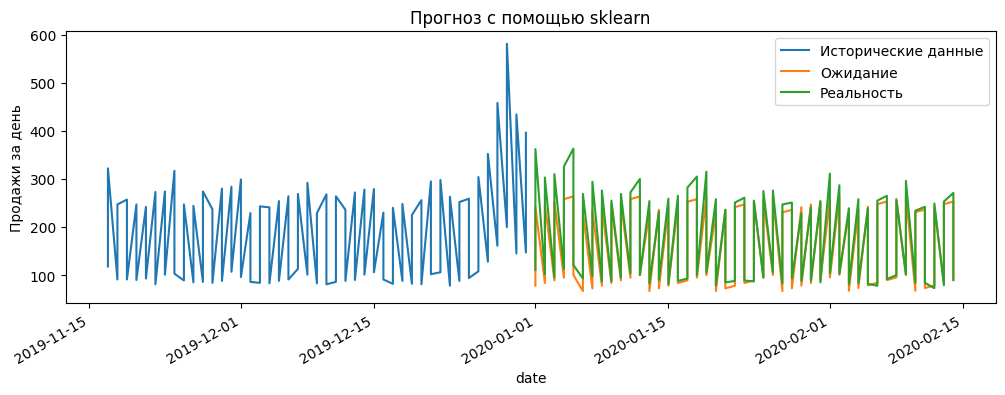

In [19]:
fig, axes = plt.subplots(figsize=(12,4))
y_train[-90:].plot(ax=axes)
predictions[:90].plot(ax=axes)
y_test[:90].plot(ax=axes)
axes.legend(['Исторические данные', 'Ожидание', 'Реальность'])
axes.set(ylabel='Продажи за день', title='Прогноз с помощью sklearn');

In [20]:
# Стандартизируем ошибки:
errors = y_test - predictions
normalized_errors = StandardScaler().fit_transform(errors.values.reshape(-1, 1))

# Сложим логарифмы их вероятностей на стандартном нормальном распределении:
log_likelihood = np.sum(st.norm.logpdf(normalized_errors))

num_params = gs.best_estimator_["model"].coef_.size + 1
2 * num_params - 2 * log_likelihood

2085.3260126116406

2081.326012611641